<a href="https://colab.research.google.com/github/DevikalyanDas/Multiclass-Segmentation/blob/main/Inference_output_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd '/content/drive/MyDrive/dataset/unet/code/'

/content/drive/MyDrive/dataset/unet/code


Found 2975 train images
Found 500 val images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


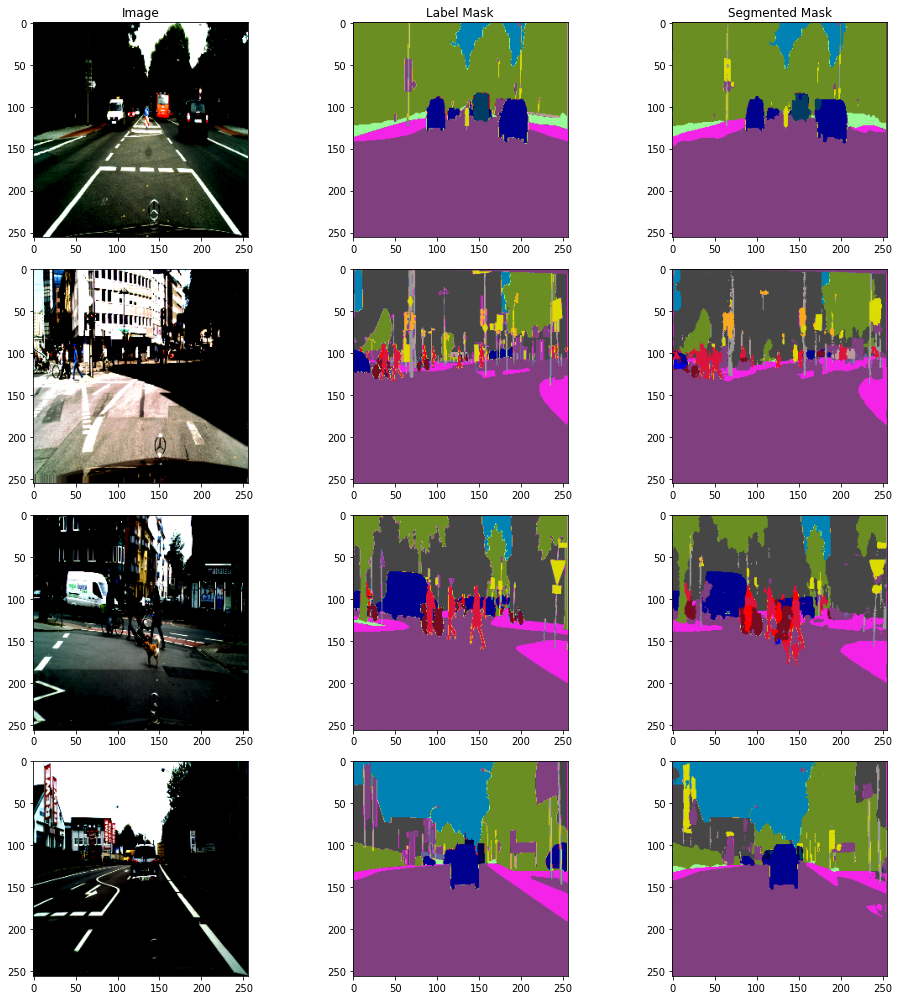

In [2]:
import os
import numpy as np
import cv2
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

from statistics import mean
import time
from tqdm import tqdm
import warnings

from vis_task_3_transforms import Compose, RandomHorizontalFlip, RandomRotate, ToTensor,Normalize
from vis_task_3_utils import recursive_glob,create_data_folder
from data_city import cityscapesLoader
from model_unet import real_unet, init_weights
from metrices1 import IoU,Fscore,Accuracy,Sensitivity,Specificity
###### data folder create #####
local_path = "/content/drive/MyDrive/dataset/data_folder/"
dst_train = cityscapesLoader(local_path, is_transform=True,split="train",img_size=(256,256))
bs = 4
trainloader = data.DataLoader(dst_train, batch_size=bs, num_workers=0,shuffle=True)

dst_val = cityscapesLoader(local_path, is_transform=False,split="val",img_size=(256,256))
val_loader = data.DataLoader(dst_val, batch_size=bs, num_workers=0,shuffle=True)

############ Model create and Initialization #############
# calling the Dilated Unet model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# summary(model, (3, 256, 256))


############loss and optimizer###################
# loss function
loss_f = torch.nn.CrossEntropyLoss()

# optimizer variable
# opt = torch.optim.Adam(model.parameters(), lr=0.001)

# # parameters 
# epochs = 200

############ 
warnings.filterwarnings("ignore")
def main():

    # loading the final epoch weight
    the_model = torch.load('/content/drive/MyDrive/dataset/unet/weights/unet_weights_epoch_199.pt',map_location=torch.device('cpu'))
    # calling the model
    with torch.no_grad():
        model_val = real_unet(n_class=19)
        # model_val = nn.DataParallel(model_val)
        model_val.to(device)
        # loading the weight to the model
        model_val.eval() 
        model_val.load_state_dict(the_model["state_dict"])                         
        for i, data_samples in enumerate(val_loader):
            imgs, labels,_ = data_samples
            imgs=imgs.to(device)
            segmented = model_val(imgs)

            segmented1 = F.softmax(segmented)
            segmented = torch.argmax(segmented1, dim=1).cpu().detach().numpy()

            imgs = imgs.cpu().permute(0,2,3,1)
            imgs = imgs.numpy()

            labels = labels.cpu().detach().numpy()

            f, ax1 = plt.subplots(bs, 3,figsize=(14,14))

            ax1[0][0].set_title('Image')
            ax1[0][1].set_title('Label Mask')
            ax1[0][2].set_title('Segmented Mask')

            for j in range(bs):
                ax1[j][0].imshow((imgs[j]))
                ax1[j][1].imshow(dst_val.decode_segmap(labels[j].astype(np.uint8)))
                ax1[j][2].imshow(dst_val.decode_segmap(segmented[j].astype(np.uint8)))
            f.tight_layout()
            plt.show()
            break

               
if __name__ == '__main__':
    main()


Writing segmented mask to folder

In [4]:
#  Writng the segmented mask to the folder

import os
import numpy as np
import cv2
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F

from statistics import mean
import time
from tqdm import tqdm
import warnings

from vis_task_3_transforms import Compose, RandomHorizontalFlip, RandomRotate, ToTensor,Normalize
from vis_task_3_utils import recursive_glob,create_data_folder
from data_city import cityscapesLoader
from model_unet import real_unet, init_weights
from metrices1 import IoU,Fscore,Accuracy,Sensitivity,Specificity
###### data folder create #####
local_path = "/content/drive/MyDrive/dataset/data_folder/"
dst_train = cityscapesLoader(local_path, is_transform=True,split="train",img_size=(256,256))
bs = 1
trainloader = data.DataLoader(dst_train, batch_size=bs, num_workers=0,shuffle=True)

dst_val = cityscapesLoader(local_path, is_transform=False,split="val",img_size=(256,256))
val_loader = data.DataLoader(dst_val, batch_size=bs, num_workers=0,shuffle=True)

############ Model create and Initialization #############
# calling the Dilated Unet model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# write folder
sv_pth = '/content/drive/MyDrive/dataset/unet/segmented_mask'

############ 
warnings.filterwarnings("ignore")
def main():

    # loading the final epoch weight
    the_model = torch.load('/content/drive/MyDrive/dataset/unet/weights/unet_weights_epoch_199.pt',map_location=torch.device('cpu'))
    # calling the model
    with torch.no_grad():
        model_val = real_unet(n_class=19)
        # model_val = nn.DataParallel(model_val)
        model_val.to(device)
        # loading the weight to the model
        model_val.eval() 
        model_val.load_state_dict(the_model["state_dict"])                         
        for i, data_samples in tqdm(enumerate(val_loader),total=len(val_loader)):
            imgs, labels,ids_n = data_samples
            imgs=imgs.to(device)
            segmented = model_val(imgs)
            segmented1 = F.softmax(segmented)
            segmented = torch.argmax(segmented1, dim=1).cpu().detach().numpy().squeeze()

            imgs = imgs.cpu().permute(0,2,3,1)
            imgs = imgs.numpy()

            labels = labels.cpu().detach().numpy()

            path_img_write = os.path.join(sv_pth,os.path.splitext(ids_n[0])[0]+"_segmented.png")
            seg_img = dst_val.decode_segmap(segmented.astype(np.uint8))
            # print(np.unique(seg_img))
            cv2.imwrite(path_img_write,cv2.cvtColor((seg_img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
            
if __name__ == '__main__':
    main()


Found 2975 train images
Found 500 val images


100%|██████████| 500/500 [05:30<00:00,  1.51it/s]
